In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("customer_subscription_churn_usage_patterns.csv")

# Convert target to binary
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

# Convert date
df['signup_date'] = pd.to_datetime(df['signup_date'])


In [3]:
df['churn'].value_counts(normalize=True)



churn
1    0.573214
0    0.426786
Name: proportion, dtype: float64

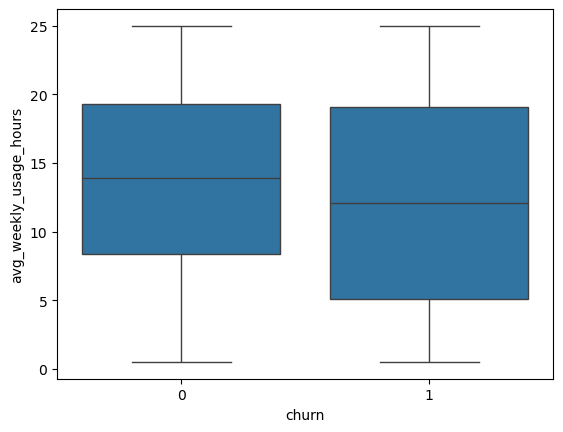

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='churn', y='avg_weekly_usage_hours', data=df)
plt.show()


In [5]:
# Encode plan_type
df = pd.get_dummies(df, columns=['plan_type'], drop_first=True)

# Drop non-predictive ID
df.drop(columns=['user_id', 'signup_date'], inplace=True)


In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.64      0.52      0.57       239
           1       0.68      0.78      0.73       321

    accuracy                           0.67       560
   macro avg       0.66      0.65      0.65       560
weighted avg       0.66      0.67      0.66       560

ROC-AUC: 0.7013647206037618


In [9]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.58      0.59      0.58       239
           1       0.69      0.68      0.69       321

    accuracy                           0.64       560
   macro avg       0.63      0.63      0.63       560
weighted avg       0.64      0.64      0.64       560

ROC-AUC: 0.7042975012708717


In [10]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_, index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)


avg_weekly_usage_hours    0.266171
last_login_days_ago       0.236405
tenure_months             0.196731
payment_failures          0.132224
support_tickets           0.126251
monthly_fee               0.019675
plan_type_Standard        0.012299
plan_type_Premium         0.010244
dtype: float64

In [12]:
y.value_counts(normalize=True)


churn
1    0.573214
0    0.426786
Name: proportion, dtype: float64

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train, y_train
)


In [14]:
y_train_smote.value_counts()


churn
1    1284
0    1284
Name: count, dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_smote = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_smote.fit(X_train_smote, y_train_smote)


RandomForestClassifier(n_estimators=200, random_state=42)

In [16]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_rf = rf_smote.predict(X_test)
y_prob_rf = rf_smote.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       0.58      0.64      0.61       239
           1       0.71      0.66      0.68       321

    accuracy                           0.65       560
   macro avg       0.65      0.65      0.65       560
weighted avg       0.66      0.65      0.65       560

ROC-AUC: 0.7109386201592826


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [18]:
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='recall')

In [19]:
best_rf = grid.best_estimator_
grid.best_params_


{'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [20]:
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))


              precision    recall  f1-score   support

           0       0.58      0.64      0.61       239
           1       0.71      0.66      0.68       321

    accuracy                           0.65       560
   macro avg       0.65      0.65      0.65       560
weighted avg       0.65      0.65      0.65       560

ROC-AUC: 0.7221548768883848
